## <p style="text-align: right;"> Nic Wiggins</p>

In order to successfully complete this assignment, you must follow all instructions in this notebook and upload your edited ipynb file with your answers on or before **11:59pm on Friday Feb. 22nd**.

**BIG HINT:** Read the entire homework before starting.  

# In-Class Assignment: Cramer's Rule

|   |   |
|---|---|
| <img src="https://upload.wikimedia.org/wikipedia/en/b/b7/Cosmo_Kramer.jpg">  | <img src="http://www.mathnstuff.com/math/algebra/gif/asys1.gif" alt="Depiction of Cramer's Rule with two equations and two variables">  |   
| [Cosmo Kramer from Sienfield (No relation)](https://en.wikipedia.org/wiki/Cosmo_Kramer)  | Image from:[http://www.mathnstuff.com/](http://www.mathnstuff.com/)  | 


    

### Outline for Homework 3

</p>
1. One application of determinants
1. Algorithm to calculate the determinant
1. Elimination method for evaluating a determinant
1. Determinant timing study
1. Using Cramer's rule to solve $Ax=b$
6. Timing study comparing Cramer's rule with Gauss-Jordan

# 1. One interplation of determinants

The following is an application of determinats. Watch this!

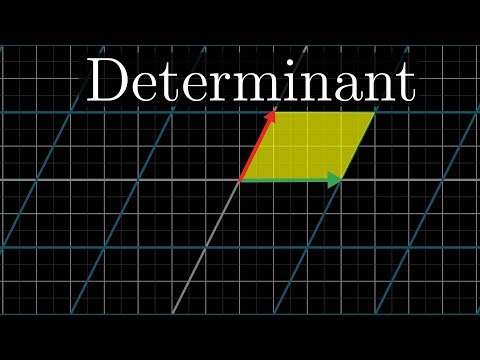

In [1]:
from IPython.display import YouTubeVideo
YouTubeVideo("Ip3X9LOh2dk",width=640,height=360)

For fun, we will recreate some of the video's visualizations in python. 
It was a little tricky to get the aspect ratios correct but here is some code I managed to get to work. 

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection, Line3DCollection
import numpy as np

In [3]:
# Lets define somme points that form a Unit Cube
points = np.array([[0, 0, 0],
                  [1, 0, 0 ],
                  [1, 1, 0],
                  [0, 1, 0],
                  [0, 0, 1],
                  [1, 0, 1 ],
                  [1, 1, 1],
                  [0, 1, 1]])

points = np.matrix(points)

In [4]:
#Here is some code to build cube from https://stackoverflow.com/questions/44881885/python-draw-3d-cube

def plot3dcube(Z):
    
    if type(Z) == np.matrix:
        Z = np.asarray(Z)

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    r = [-1,1]

    X, Y = np.meshgrid(r, r)
    # plot vertices
    ax.scatter3D(Z[:, 0], Z[:, 1], Z[:, 2])

    # list of sides' polygons of figure
    verts = [[Z[0],Z[1],Z[2],Z[3]],
     [Z[4],Z[5],Z[6],Z[7]], 
     [Z[0],Z[1],Z[5],Z[4]], 
     [Z[2],Z[3],Z[7],Z[6]], 
     [Z[1],Z[2],Z[6],Z[5]],
     [Z[4],Z[7],Z[3],Z[0]], 
     [Z[2],Z[3],Z[7],Z[6]]]

    #alpha transparency was't working found fix here: 
    # https://stackoverflow.com/questions/23403293/3d-surface-not-transparent-inspite-of-setting-alpha
    # plot sides
    ax.add_collection3d(Poly3DCollection(verts, 
     facecolors=(0,0,1,0.25), linewidths=1, edgecolors='r'))
    
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    
    ## Weird trick to get the axpect ratio to work.
    ## From https://stackoverflow.com/questions/13685386/matplotlib-equal-unit-length-with-equal-aspect-ratio-z-axis-is-not-equal-to
    ax.set_aspect('equal')
    mx = np.amax(Z, axis=0)
    mn = np.amin(Z, axis=0)
    max_range = mx-mn

    # Create cubic bounding box to simulate equal aspect ratio
    Xb = 0.5*max_range.max()*np.mgrid[-1:2:2,-1:2:2,-1:2:2][0].flatten() + 0.5*(max_range[0])
    Yb = 0.5*max_range.max()*np.mgrid[-1:2:2,-1:2:2,-1:2:2][1].flatten() + 0.5*(max_range[1])
    Zb = 0.5*max_range.max()*np.mgrid[-1:2:2,-1:2:2,-1:2:2][2].flatten() + 0.5*(max_range[2])
    # Comment or uncomment following both lines to test the fake bounding box:
    for xb, yb, zb in zip(Xb, Yb, Zb):
       ax.plot([xb], [yb], [zb], 'w')

    plt.show()

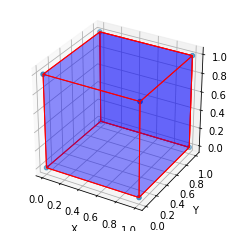

In [5]:
plot3dcube(points)

<font color='red'>**Question:**</font> Generate the $3\times 3$ matrix used in the video (around 6'50'') and apply that matrix to the points in the unit cube.  Use ```plot3dcube``` to show the resulting transformed points. 

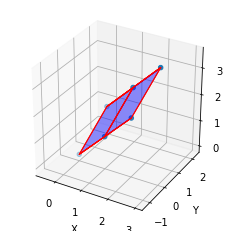

In [6]:
m = np.matrix([[1.0,0.0,1.0],[0.5,1.0,1.5],[1.0,0.0,1.0]])
plot3dcube(points*m)

<font color='red'>**QUESTION:**</font> In the video, the determinant was shown to be what value in 2D? 

Determinant is 0, which transforms the cube into a plane

---
# 2. Algorithm to calculate the determinant
Consider the following recursive algorithm (algorithm that calls itself) to determine the determinate of a $n\times n$ matrix $A$ (denoted $|A|$), which is the sum of the products of the elements of any row or column. i.e.:

$$i\text{th row expansion:     } |A| = a_{i1}C_{i1} + a_{i2}C_{i2} + \ldots + a_{in}C_{in} $$
$$j\text{th column expansion:     } |A| = a_{1j}C_{1j} + a_{2j}C_{2j} + \ldots + a_{nj}C_{nj} $$

where $C_{ij}$ is the cofactor of $a_{ij}$ and is given by:

$$ C_{ij} = (-1)^{i+j}|M_{ij}|$$

and $M_{ij}$ is the matrix that remains after deleting row $i$ and column $j$ of $A$.

Using the above steps, the determinant can be calculated in $O(n!)$ time!.  

Here is some code that tries to implement this algorithm.  

In [7]:
## Import our standard packages packages
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import sympy as sym
sym.init_printing(use_unicode=True)

In [8]:
import copy
import random

def makeM(A,i,j):
    ''' Deletes the ith row and jth column from A'''
    M = copy.deepcopy(A)
    del M[i]
    for k in range(len(M)):
        del M[k][j]
    return M

def mydet(A):
    '''Calculate the determinant from list-of-lists matrix A'''
    n = len(A)
    if n == 2:
        det = (A[0][0]*A[1][1] - A[1][0]*A[0][1]) 
        return det
    det = 0
    i = 0
    for j in range(n):
        M = makeM(A,i,j)
        
        #Calculate the determinant
        det += (A[i][j] * ((-1)**(i+j+2)) * mydet(M))
    return det

The following code generates an $n \times n$ matrix with random values from 0 to 10.  
Run the code multiple times to get different matrices:

In [9]:
#generate Random Matrix and calculate it's determinant using numpy
n = 5
s = 10
A = [[round(random.random()*s) for i in range(n)] for j in range(n)]

#print matrix
sym.Matrix(A)

⎡3  7  9  9  2 ⎤
⎢              ⎥
⎢9  4  2  0  10⎥
⎢              ⎥
⎢7  7  6  1  9 ⎥
⎢              ⎥
⎢2  6  5  2  1 ⎥
⎢              ⎥
⎣6  1  5  1  1 ⎦

&#9989; <font color='red'>**DO THIS:**</font> Use the randomly generated matrix ($A$) to test the above ```mydet``` function and compare your result to the ```numpy.linalg.det``` function.

In [10]:
print("mydet: ",mydet(A),". numpy: ",np.linalg.det(A))

mydet:  -5256 . numpy:  -5256.000000000004


&#9989; <font color=red>**QUESTION:**</font> Are the answers to ```mydet``` and ```numpuy.linalg.det``` exactly the same every time you generate a different random matrix?  If not, explain why.

Not exactly the same, numpy is typically off by a few decimal places. Numpy is optimized and is calculated numerically so there will always be some error. 

&#9989; <font color=red>**QUESTION:**</font> On line 24 of the above code, you can see that algorithm calls itself.  Explain why this doesn't run forever.

Line 15, once it reaches a 2x2 matrix it finally returns the determinant

# 3. Elimination method for evaluating a determinant

Assume the following is true

> The determinant of a triangular matrix is the product of its diagonal elements.

If we transform a $n\times n$ matrix $A$ into it's upper triangular form, we can calculate the determinant of $A$ if we keep track of the elementary row operations and adjust the upper triangular determinate using the following rules:

1. Add a multiple of one row to another. This transform leaves the determinant unchanged.
2. Interchange two rows of $A$. This transformation multiplies the determinant by -1. 
3. Multiply one row by $c$. This transformation multiplies the determinant by $c$

&#9989; <font color=red>**QUESTION:**</font> What is the computational complexity of using elimination method (Gauss-Jordan) for evaluating the determinant? Explain how you came up with this estimation and/or provide a reference.

n(n + 1)/2 divisions

(2n^3 + 3n^2 − 5n)/6 multiplications

(2n^3 + 3n^2 − 5n)/6 subtractions

Added together gives O(n^3)

https://en.wikipedia.org/wiki/Gaussian_elimination


# 4. Determinant timing study

&#9989; <font color=red>**DO THIS:**</font> In this part of the homework, we want you to do a timing study to measure the time taken to run the ```mydet``` algorithm defined in part 2 and compare it to the elimination (Gaussian) method for evaluating a determinant as described in part 3.  Assume that the ```numpy.linalg.det``` function uses elimination method to calculate the determinant.  

Here is the basic structure of your timing study:

1. Initialize two empty lists called ```my_det_time``` and ```np_det_time```.
2. Loop over values of $n$ (2, 3, 4, 5, 6, 7, 8, 9)  **HINT:** Do NOT make $n$ bigger than 9.  If you do, the ```mydet``` function will take a very long time.
3. For each value of $n$, generate a list-of-lists of size $n \times n$ of random values to serve as matrix $A$.
4. For each matrix $A$, use the time.clock() function to calculate the time it takes to find the determinant using the ```mydet``` function and append that time (in seconds) to the ```my_det_time``` list.
5. For each matrix $A$, use the time.clock() function to calculate the time it takes to find the determinant using the ```numpy``` determinate function and append that time (in seconds) to the ```numpy_time``` list.
6. Plot your results (Make sure you label your figure appropriately)

/Users/nicwiggins/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  # Remove the CWD from sys.path while we load stuff.
/Users/nicwiggins/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  if sys.path[0] == '':
/Users/nicwiggins/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  
/Users/nicwiggins/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.

[5.999999999994898e-05, 0.00011899999999975819, 0.0007489999999998886, 0.0021100000000000563, 0.010101000000000138, 0.08088799999999985, 0.6048689999999999, 4.814787]
[0.0003709999999998992, 9.499999999995623e-05, 8.200000000035956e-05, 9.499999999995623e-05, 0.0001180000000000625, 9.299999999967667e-05, 0.00013599999999991397, 0.00010500000000135401]


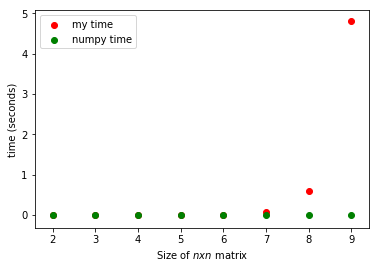

In [11]:
import time

my_det_time = []
np_det_time = []

for n in range(2,10):
    #Generate A
    A = [[round(random.random()*10) for i in range(n)] for j in range(n)]
    
    t0 = time.clock()
    d = mydet(A)
    my_det_time.append(time.clock() - t0)
    
    t0 = time.clock()
    d = np.linalg.det(A)
    np_det_time.append(time.clock() - t0)
    
print(my_det_time)
print(np_det_time)

plt.scatter(range(2,10),my_det_time, color='red', label = 'my time')
plt.scatter(range(2,10),np_det_time, color='green', label='numpy time')

plt.xlabel('Size of $n x n$ matrix');
plt.ylabel('time (seconds)')
plt.legend();

---
# 5. Using Cramer's rule to solve $Ax=b$

Let $Ax = b$ be a system of $n$ linear equations in $n$ variables such that $|A| \neq 0$. the system has a unique solution given by:

$$x_1 = \frac{|A_1|}{|A|}, x_2 = \frac{|A_2|}{|A|}, \ldots,  x_n = \frac{|A_n|}{|A|}$$

where $A_i$ is the matrix obtained by replacing column $i$ of $A$ with $b$ (See diagram at the beginning of this homework). The following function generates $A_i$ by replacing the $i$th column of $A$ with $b$:

In [12]:
def makeAi(A,i,b):
    '''Replace the ith column in A with b'''
    Ai = copy.deepcopy(A)
    for j in range(len(Ai)):
        Ai[j][i] = b[j][0]
    return Ai

&#9989; <font color=red>**DO THIS:**</font> Create a new function called ```cramersRule```, which takes $A$ and $b$ and returns $x$ using the Cramer's rule. **Note:** Use ```numpy``` and NOT ```mydet``` to find the required determinants. ```mydet``` is too slow. 

In [13]:
# Stub code. Replace the np.linalg.solve code with your answer

def cramersRule(A,b):
    x = np.empty((len(A[1]),1))
    for i in range (0,len(A[1])):
        x[i] = np.linalg.det(makeAi(A,i,b))/np.linalg.det(A)
    return x

&#9989; <font color=red>**QUESTION:**</font> Test your ```cramersRule``` function on the following system of linear equations:

$$ x_1 + 2x_2 = 3$$
$$3x_1 + x_2 = -1$$

In [14]:
A = np.array([[1,2],[3,1]])
b = np.array([[3],[-1]])

cramersRule(A,b)

array([[-1.],
       [ 2.]])

&#9989; <font color=red>**QUESTION:**</font> Verify the above answer by using the ```np.linalg.solve``` function:

In [15]:
np.linalg.solve(A,b)

array([[-1.],
       [ 2.]])

&#9989; <font color=red>**QUESTION:**</font> Test your ```cramersRule``` function on the following system of linear equations and verify the answer by using the ```np.linalg.solve``` function: 

$$ x_1 + 2x_2 +x_3 = 9$$
$$ x_1 + 3x_2 - x_3 = 4$$
$$ x_1 + 4x_2 - x_3 = 7$$

In [16]:
A = np.array([[1,2,1],[1,3,-1],[1,4,-1]])
b = np.array([[9],[4],[7]])

x = cramersRule(A,b)
print(np.isclose(x,np.linalg.solve(A,b)))
x

[[ True]
 [ True]
 [ True]]


array([[-1.],
       [ 3.],
       [ 4.]])

&#9989; <font color=red>**QUESTION:**</font> Cramer's rule is a $O(n!)$ algorithm and the Gauss-Jordan (or Gaussian) elimination is $O(n^3)$.  What advantages does Cramer's rule have over elimination?

For lower dimensions (in theory n = 5 and smaller, in practice n =2 or 3) its actually faster. Cramer's rule is prefered if you only need the answer and don't want additional information that Gaussian elimnation gives you. 

# 6. Timing study comparing Cramer's rule with Gaussian
The following code conducts a timing study to compare your Cramer's rule with Gaussian (aka ```numpy.linalg.solve```).  
The code generates a random system of linear equations in the form of $Ax=b$ and then attempt to solve them using both methods.  

In [21]:
import time

n_list = [2, 3, 4, 5, 6, 7, 8, 9, 10 , 11, 12, 13, 14, 15 ]
cramer_time = []
numpy_time = []

for n in n_list:
    #Generate random nxn array of two lists
    A = [[0,0],[0,0]]
    while np.linalg.det(A) == 0:
        A = [[random.random() for i in range(n)] for j in range(n)]
    b = [[random.random()] for i in range(n)]
    
    start = time.time()
    x = cramersRule(A, b)
    stop = time.time()
    cramer_time.append(stop - start)
    
    #Convert the lists to a numpy matrix
    nA = np.matrix(A)
    nb = np.matrix(b)

    #Calculate the time it takes to run the numpy matrix. 
    start = time.time()
    x2 = np.linalg.solve(A,b)
    stop = time.time()
    numpy_time.append(stop - start)

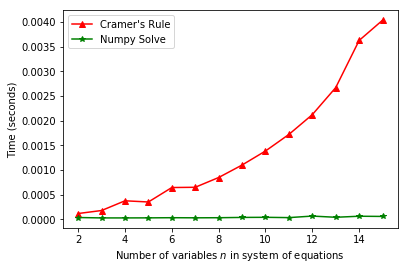

In [22]:
plt.plot(n_list, cramer_time, 'r-^', label="Cramer's Rule")
plt.plot(n_list, numpy_time, 'g-*', label='Numpy Solve')
plt.xlabel('Number of variables $n$ in system of equations');
plt.ylabel('Time (seconds)');
plt.legend();

Based on the above results, you can see that the numpy algorithm not only is faster but also "scales" at a slower rate than cramer's rule.  

&#9989; <font color=red>**QUESTION:**</font> The following is a list of all of the different algorithms we have used so far to solve systems of equations in the form of $Ax=b$. Do the following:

1. Include the missing big-O notations. (Jacobi and Gauss-Sideal provided).
2. Reorder the algorithms from slowest to fastest. 
3. Include any limitations for each approach (example provided for Jacobi).

* Slowest
* Cramer's rule is $O(n!)$
    - Requires computation of n + 1 determinants
* One iteration of the Jacobi method is $O(n^2)$ (many iterations are needed often > n) [REF](http://shodhganga.inflibnet.ac.in/bitstream/10603/148188/9/09_chapter%203.pdf) 
    - Only works for diagonally dominant matrices
    - Convergence Required
    - Doesn't use updated values in iteration
* One iteration of the Gauss-Sideal method is $O(n^2)$ (many iterations are needed often > n) [REF](http://shodhganga.inflibnet.ac.in/bitstream/10603/148188/9/09_chapter%203.pdf)
    - Convergence Required
    - Convergence is only guaranteed if the matrix is either diagonally dominant, or symmetric and positive definite. 
* Elimination method is $O(n^3)$
    - Potential numerical instability when diagonally dominant nor positive-definite 
* LU Decomposition and then forward and backward substitution is $O(n^3)$
    - Without a proper ordering or permutations in the matrix, the factorization may fail to materialize

* Fastest

-----
### Congratulations, we're almost done!

Now, you just need to submit this assignment by uploading it to the course <a href="https://d2l.msu.edu/">Desire2Learn</a> web page for the homework's dropbox (Don't forget to add your names in the first cell).


&#169; Copyright 2018,  Michigan State University Board of Trustees